# Welcome to NameWeave - Manual Backpropagation

Let's rearrange our last code from <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20(MLP)%20-%20Activations%2C%20Gradients%20%26%20Batch%20Normalization.ipynb">NameWeave (MLP) - Activations, Gradients & Batch Normalization</a> file, to come back to the part where we were at the end of the file.

In this lecture, we will not try to achieve a very low loss (We would get around the same loss that we had before) or dive into any complexifying architecture to improve our performance in the names prediction, rather we would be diving into the manual back propagation...

Why would we do this you ask?

Because, back in the days of around 2012, everybody used to write the backward pass manually, and you can *shoot yourself in the foot* if you don't know how to manually back propagate through, while debugging a neural network when you run into optimization issues and much more...

Also, back propagation is a <a href="https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b#:~:text=%3E%20The%20problem%20with%20Backpropagation%20is,them%20work%E2%80%9D%20on%20your%20data.">leaky abstraction</a>. Try to look into Andrej's beautiful medium post about back propagation.

In this notebook, we would divide the excercises into 4 parts:
1. Manual Back Propagation for each and every expression
2. Manual Back Propagation through fast cross_entropy (Combined Back Propagation)
3. Manual Back Propagation through batch normalization (Combined Back Propagation)
4. Putting all the code together for manual `loss.backward()`

**Typically we would use the general `loss.backward()` nowadays (which is PyTorch's auto-grad engine), and not everybody knows how to backpropagate through the neural networks manually, but we would learn to manually do it, just like we used to, back in the days...**

Such that, this meme becomes relatable:
![Manual Back Propagation Meme](ExplanationMedia/Images/ManualBackPropMeme.png)

# Installing Dependencies

In [1]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install matplotlib

# Importing Libraries


In [2]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\avhis\AppData\Local\Temp\ipykernel_7860\3082457058.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Loading Dataset

In [3]:
words = open("Datasets/Indian_Names.txt").read().splitlines()
words = [word.lower() for word in words]

In [4]:
len(words)

53982

# Building Vocabulary

In [5]:
# Remember we need our starting and ending tokens as well in these mappings,
characters = sorted(list(set(''.join(words)))) # Gives us all the characters in the english alphabet, hopefully our dataset has all of them
stoi = {s:i+1 for i,s in enumerate(characters)} # Enumerate returns the tuples of number and string, which can then be mapped to string:index
# We manually add these tokens for convenience
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # After we have the string:index mapping, we can easily iterate over their items to map index:string
print("Characters:", characters)
print("STOI:", stoi)
print("ITOS", itos)
# We define a common vocabulary size
vocabularySize = len(stoi)
print("Vocabulary Size:", vocabularySize)

Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
STOI: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
ITOS {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocabulary Size: 27


# Building Dataset

In [6]:
# We define a Block Size based on the number of characters we feed are going to feed to predict the next one
blockSize = 3
# Will build the dataset on only the words we take as input
def buildDataset(words):
    # We define two lists, inputs & outputs, where inputs are our blocks of the block size mentioned above and outputs are the label indexes
    inputs , outputs = [], []
    # We iterate over each word
    for word in words:
        # We define the block for each iteration and fill it with 0 values -> [0, 0, 0]
        block = [0] * blockSize
        # We run another loop for each word's character, here word also needs the ending token '.'
        for character in word + '.':
            # We take out the index from our look-up table
            index = stoi[character]
            # We append the input with our block
            inputs.append(block)
            # We append the output label with out index of the character
            outputs.append([index])
            # We then take the block, crop it 1 size from the left and append the next index to it (sliding window of name)
            block = block[1:] + [index]
    # We also convert these inputs and outputs to tensors for neural network processing
    inputs = torch.tensor(inputs)
    outputs = torch.flatten(torch.tensor(outputs))
    # We return the inputs and outputs
    return inputs, outputs

# We define a manual seed to random
random.seed(69)
# We shuffle all the words, so that the model receives all kinds of data
random.shuffle(words)
# We define two number of inputs
# We take the number of examples to 80% in the first variable
numberOfInputs1 = int(0.8*len(words))
# We take the number of examples to 90% in the first variable
numberOfInputs2 = int(0.9*len(words))
# Inputs and outputs that go till 80% of the examples
trainingInputs, trainingOutputs = buildDataset(words[:numberOfInputs1])
# Inputs and outputs that start at 80% of the examples and go till 90% of the examples
validationInputs, validationOutputs = buildDataset(words[numberOfInputs1:numberOfInputs2])
# Inputs and outputs that start at 90% of the examples
testInputs, testOutputs = buildDataset(words[numberOfInputs2:])

# We can check the numbers
print("Total Examples:",len(words)) # 100%
print("Training Examples:",len(words[:numberOfInputs1])) # 80%
print("Validation Examples:",len(words[numberOfInputs1:numberOfInputs2])) # 10%
print("Test Examples:",len(words[numberOfInputs2:])) # 10%

Total Examples: 53982
Training Examples: 43185
Validation Examples: 5398
Test Examples: 5399


# Utility Function to Compare Gradients

We would also use a new utility function in this lecture to compare the gradients in this lecture.\
The utility function tells us if we have an exact match, an approximate match and the maximum difference we have in our gradients.

In [7]:
def compare_gradients(description, manual_gradient, torch_tensor):
    """
    Compare manual gradients with PyTorch gradients.

    Parameters:
    - description: A string describing the comparison.
    - manual_gradient: The manually computed gradient.
    - torch_tensor: The PyTorch tensor for which gradients are computed.

    Prints the comparison results including exact match, approximate match, and maximum difference.
    """
    exact_match = torch.all(manual_gradient == torch_tensor.grad).item()
    approximate_match = torch.allclose(manual_gradient, torch_tensor.grad)
    max_difference = (manual_gradient - torch_tensor.grad).abs().max().item()
    print(f'{description:35s} | Exact: {str(exact_match):5s} | Approximate: {str(approximate_match):5s} | MaxDiff: {max_difference}')

# Neural Network Initialization - Weights, Biases & Parameters

You will see that I changed the initialization for the parameters to be small numbers...\
Normally you would set the biases to be all zeros, but I did set the biases to be small numbers...\
Sometimes if your variables are initialized at exactly zero, it can mask an incorrect implementation of a gradient...

You will also notice, unlike last time, we are still using the biases for the First Hidden Layer, despite of the batch normalization which is just for fun (we are going to have a gradient with respect to it and we can check wheter we are calculating it correctly or not...

In [8]:
# We will define a generator to give the same result on your machine, as of my machine
generator = torch.Generator().manual_seed(6942069420)
# Embedding Matrix (Input Layer)
embeddingFeatureSpaceLength = 10 
embeddingLookUpMatrix = torch.randn((vocabularySize, embeddingFeatureSpaceLength), generator=generator)
# Hidden Layer
numberOfHiddenLayerNeurons = 64
weightsOfHiddenLayer = torch.randn((blockSize*embeddingFeatureSpaceLength), numberOfHiddenLayerNeurons, generator=generator) * (5/3) / ((embeddingFeatureSpaceLength*blockSize)**0.5)
biasesOfHiddenLayer = torch.randn(numberOfHiddenLayerNeurons, generator=generator) * 0.1
# Output Layer / Final Layer
weightsOfFinalLayer = torch.randn(numberOfHiddenLayerNeurons, vocabularySize, generator=generator) * 0.1
biasesOfFinalLayer = torch.randn(vocabularySize, generator=generator) * 0.1
# Batch Normalization Layer
batchGains = torch.randn((1, numberOfHiddenLayerNeurons)) * 0.1 + 1.0
batchBiases = torch.randn((1, numberOfHiddenLayerNeurons)) * 0.1
# Parameters
parameters = [embeddingLookUpMatrix, weightsOfHiddenLayer, biasesOfHiddenLayer, weightsOfFinalLayer, biasesOfFinalLayer, batchGains, batchBiases]
# We set all the requires gradient to True
for parameter in parameters:
    parameter.requires_grad = True

# Forward Pass

You will see that we will significantly expand the forward pass because we have some lines of code like the 
```python
loss = F.cross_entropy(logits, trainingOutputs[indexes])
```
which is very much not understandable of what works under the hood, so I tried to bring back some of the explicit implementation of the loss function that we have inside the PyTorch's `cross_entropy` method.

Also, we will be running the forward pass for only 1 epoch for the time being, until we figure out all the back propagation elements, and we will be prepending a 'd' in front of the variables to make them understandable as backward pass variables in the context of $\frac{d}{dx}y$ equations.

Note: This back propagation is going to be way different than what we did back in our original <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/Neural%20Network%20with%20Derivatives.ipynb">Neural Network with Derivatives</a> notebook, because in that notebook we had single (individual) scalars, but here we have entire layers of neurons and we want to backpropagate through the entirity of them.

In [9]:
batchSize = 32
indexes = torch.randint(low=0, high=trainingInputs.shape[0], size=(batchSize,))
inputBatch, outputBatch = trainingInputs[indexes], trainingOutputs[indexes]
# Forward Pass Start
embedding = embeddingLookUpMatrix[inputBatch]
concatenatedEmbedding = embedding.view(embedding.shape[0], -1)
# Linear Layer - 1
hiddenLayerPreBatchNormStates = concatenatedEmbedding @ weightsOfHiddenLayer + biasesOfHiddenLayer
# Batch Normalization Layer
batchMeanAtIteration = 1/batchSize*hiddenLayerPreBatchNormStates.sum(0, keepdim=True)
batchDifference = hiddenLayerPreBatchNormStates - batchMeanAtIteration
batchDifferencePow2 = batchDifference**2
batchVariance = 1/(batchSize - 1)*(batchDifferencePow2).sum(0, keepdim=True) # Note: Bessel's Correction (which is division by n-1 instead of n)
batchVarianceInverse = (batchVariance + 1e-5)**-0.5
batchRawValue = batchDifference * batchVarianceInverse
hiddenLayerPreActivationStates = batchGains * batchRawValue + batchBiases
# Non-Linearity Layer
hiddenLayerPostActivationStates = torch.tanh(hiddenLayerPreActivationStates)
# Linear Layer - 2
logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
# Cross Entropy Loss (Same as F.cross_entropy() method)
maxLogits = logits.max(1, keepdim=True).values
normalizedLogits = logits - maxLogits # Subtracting it for numerical stability
counts = normalizedLogits.exp()
sumCounts = counts.sum(1, keepdims=True)
sumCountsInverse = sumCounts**-1 # For some reason (1/sumCounts) does not output with exact back propagation
probabilities = counts * sumCountsInverse
logProbabilities = probabilities.log()
loss = -logProbabilities[range(batchSize), outputBatch].mean()

# Backward Pass (Mini-Batch)
for parameter in parameters:
    parameter.grad = None
# Rataining Gradient For Checking It Later
for item in [logProbabilities, probabilities, sumCountsInverse, sumCounts, counts, normalizedLogits, maxLogits, logits, 
             hiddenLayerPostActivationStates, hiddenLayerPreActivationStates, batchRawValue, batchVarianceInverse,
             batchVariance, batchDifferencePow2, batchDifference, batchMeanAtIteration, hiddenLayerPreBatchNormStates,
             concatenatedEmbedding, embedding]: # I am sorry, but I did not find a much cleaner way to do this XD
    item.retain_grad()
loss.backward()
print("Loss:", loss)

Loss: tensor(3.3591, grad_fn=<NegBackward0>)


# Manual Back Propagation

In this exercise we will back propagate through the entire forward pass for all the small expressions, one-by-one...

So let's start...

### Cross Entropy Back Propagation

Let's understand what we are trying to achieve in the first place...

At the very beginning we are trying to calcualate the gradients of the loss...

In the context of sensitivity analysis, **gradients represent how sensitive one variable (output) is to small changes in another variable (input)**.

So, we are trying to know that **how sensitive the `loss` is in small changes to `logProbabilities`**...

Let's understand what $\log{}$ is first...

$\log{}\rightarrow\text{Inverse Function to Exponentiation}$

For example:\
$1000 = 10^3 \rightarrow \log_{10}(1000) \rightarrow 3$\
Or\
$x = b^y \rightarrow \log_{10}(x) \rightarrow y$

And we have natural logarithms as well... Also represented as $\ln{}$...\
Here we do $y=e^x\rightarrow\log_e{x}\rightarrow\ln{x}$.


Here we see that `e` is the base, and `e` is also known as the Euler's Number

$$ e = \sum\limits_{n=0}^\infty\frac{1}{n!} = \frac{1}{0!} + \frac{1}{1!} + \frac{1}{2!} + \frac{1}{3!} +...$$

So what is $\frac{d}{dx}(\log{(x)})$?

Well, $\frac{d}{dx}(\log{(x)}) = \frac{1}{x}$

Also if we remember $\log{}$ from our school days of mathematics, we know that $\log{(a.b.c)}=\log(a)+\log(b)+\log(c)$

Let's first understand what are we doing in this line:
```python
loss = -logProbabilities[range(batchSize), outputBatch].mean()
```

`range(batchSize)` gives us an array of `32` numbers from `0` to `31`, when we index into `logProbabilities` using `range()` and `outputBatch` range is essentially using all the `32` rows of the output and *plucking-out* all the **`logProbabilities` of the correct next character**, then it is averaging them using `mean()` and we are taking the `negetive` of that number.

So from all the above explanations we come to a simpler way of trying to evaluate something complex...\
Here in this line `loss = -logProbabilities[range(batchSize), outputBatch].mean()` we are doing something like:\
$$\text{loss} = -(a + b + c)/3$$
So if we do $\frac{dLoss}{da}$ we get:
$$loss = -\frac{1}{3}a + -\frac{1}{3}b + -\frac{1}{3}c$$\
Or $\frac{dLoss}{da} = -\frac{1}{3}$\
Or we can say that it is $-\frac{1}{n}$ of only those indexes who participate, otherwise all the other gradients remain 0.

But now we have to stay careful, because we understand that we don't have an individual scalar here...\
If we check the size of the `logProbabilities` using:
```python
print(logProbabilities.shape)
```
we get a shape like:
```python
torch.Size([32, 27])
```

And by this time, it should not surprise us, that the shape of the tensor remain the same because we are doing element-wise operations and assigning gradients to the same locations as the original tensor.

So now what we can do is, we can create a tensor of zeros and only fill the indexes with equation $-1/n$ where the indeces participate...

(For us `n` is the `batchSize`)

In [10]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0


Congratulations...\
We did our very first step...

Let's do the next step now...

For 
```python
logProbabilities = probabilities.log()
```

Once again,
$$\frac{d}{dx}\log{(x)} = \frac{1}{x}$$

But now, because this is an intermediate node, we have to be careful for local and global derivatives as well...

So, we will have $1/\text{Probailities}$ as the **local derivative** and our already caculated `dLogProbabilities` as our global derivative...

In [11]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities


# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0


Seems like, we are very well on track... 😊

Let's now do the back propagation for this line:
```python
probabilities = counts * sumCountsInverse
```

But now we have to be careful about these items, because the shape of `counts` and `sumCountsInverse` are `torch.Size([32, 27])` and `torch.Size([32, 1])` respectively...\
So there is an internal broadcasting that is happening within this expression...

Let's understand what is happening here with a small *toy-example*:

If $c = a*b$ (with Tensors), where $a\rightarrow\text{[3, 3]}$, $b\rightarrow\text{[3, 1]}$, $c\rightarrow\text{[3, 3]}$

<table>
<tr><td>

|          |          |          |
|----------|----------|----------|
| $a_{11}$ | $a_{12}$ | $a_{13}$ |
| $a_{21}$ | $a_{22}$ | $a_{23}$ |
| $a_{31}$ | $a_{32}$ | $a_{33}$ |

</td><td>

$.$

</td><td>

|       |
|-------|
| $b_1$ |
| $b_2$ |
| $b_3$ |

</td><td>

$\rightarrow$

</td><td>

|                |                |                |
|----------------|----------------|----------------|
| $a_{11} * b_1$ | $a_{12} * b_1$ | $a_{13} * b_1$ |
| $a_{21} * b_2$ | $a_{22} * b_2$ | $a_{23} * b_2$ |
| $a_{31} * b_3$ | $a_{32} * b_3$ | $a_{33} * b_3$ |

</td></tr> 
</table>

We see that in this *toy-example*, PyTorch internally replecates the elements of `'b'` across all the columns.

And the **most important** thing to note is that, even if this expression looks like a single expression, but is actually a dual operation, happening sequentially...

How you ask?

Well, its easy really...\
First it takes all the elements of 'b' and replecates it accross all the columns of 'a' and then eventually it the *multiplication* takes place...

So, let's back propagate through the *multiplication* first...

Now, if we are using our old $\text{chain rule} = \text{local derivative} * \text{global derivative}$ rule for our multiplication, we get:\
counts $\rightarrow$ local derivative\
dProbabilities $\rightarrow$ global derivative

So:
```python
dSumCountsInverse = counts * dProbabilities
```

Simple right?

Not quite...

Remember this is a dual-operation happening sequentially? So we need to handle the replecated 'b' next...

So how do we handle **replecated** value?

Well, if we look at any random detailed back propagation with scalars example, we see:

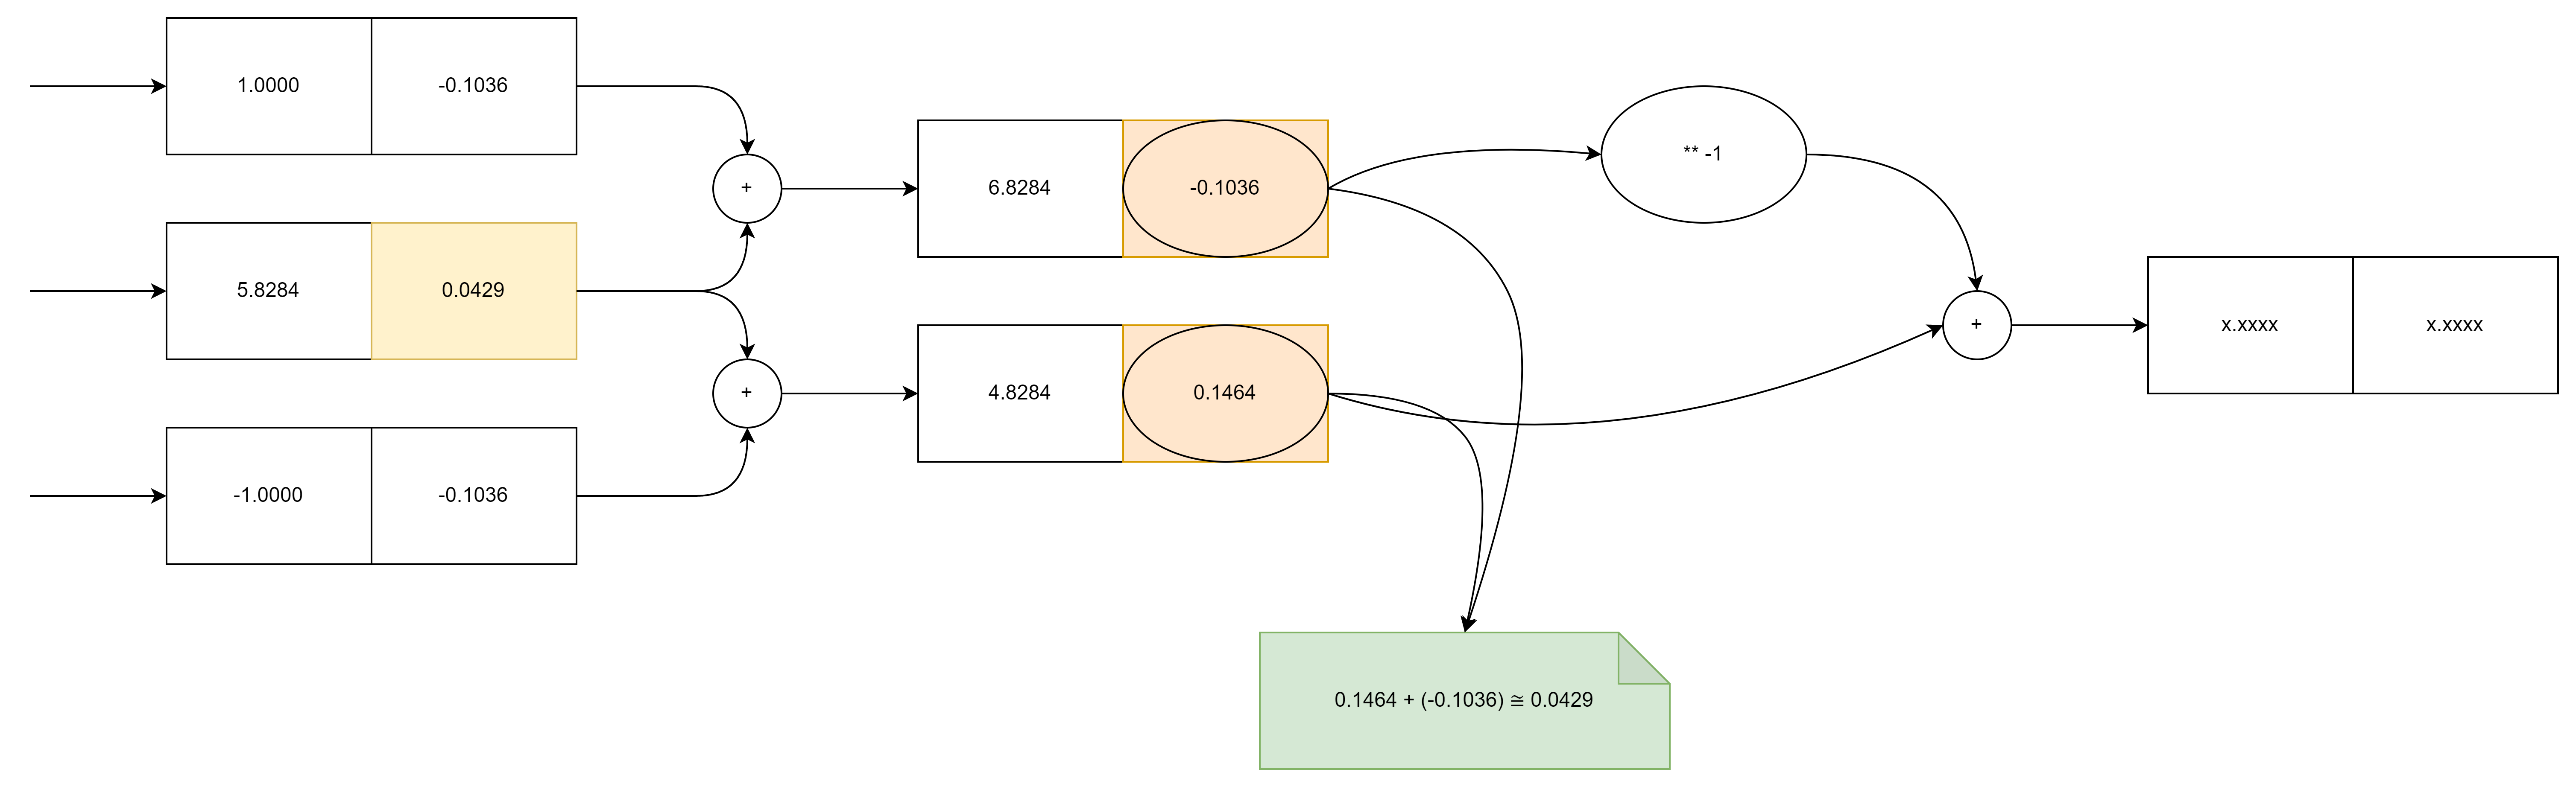

We see that whenever the same branch is getting fed into multiple other branches as an output, the gradients of the output eventually add up and make up the gradient of the input branch...

Therefore, the right thing to do is to sum up those values...

And so we will arrive at a point where are replicating the columns (dimension-1) along 'a', and thus, we should sum up the gradients along the first dimension and we need to be careful of broadcasting as well...

So now our back propagation looks like:

In [12]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0


We see that we get and exact match along the lines.

Yaayy... 😊

Now we arrive at a problematic part when we try to derive `'dCounts'` as well...

Why?

Let's look at what `counts` is associated with first...

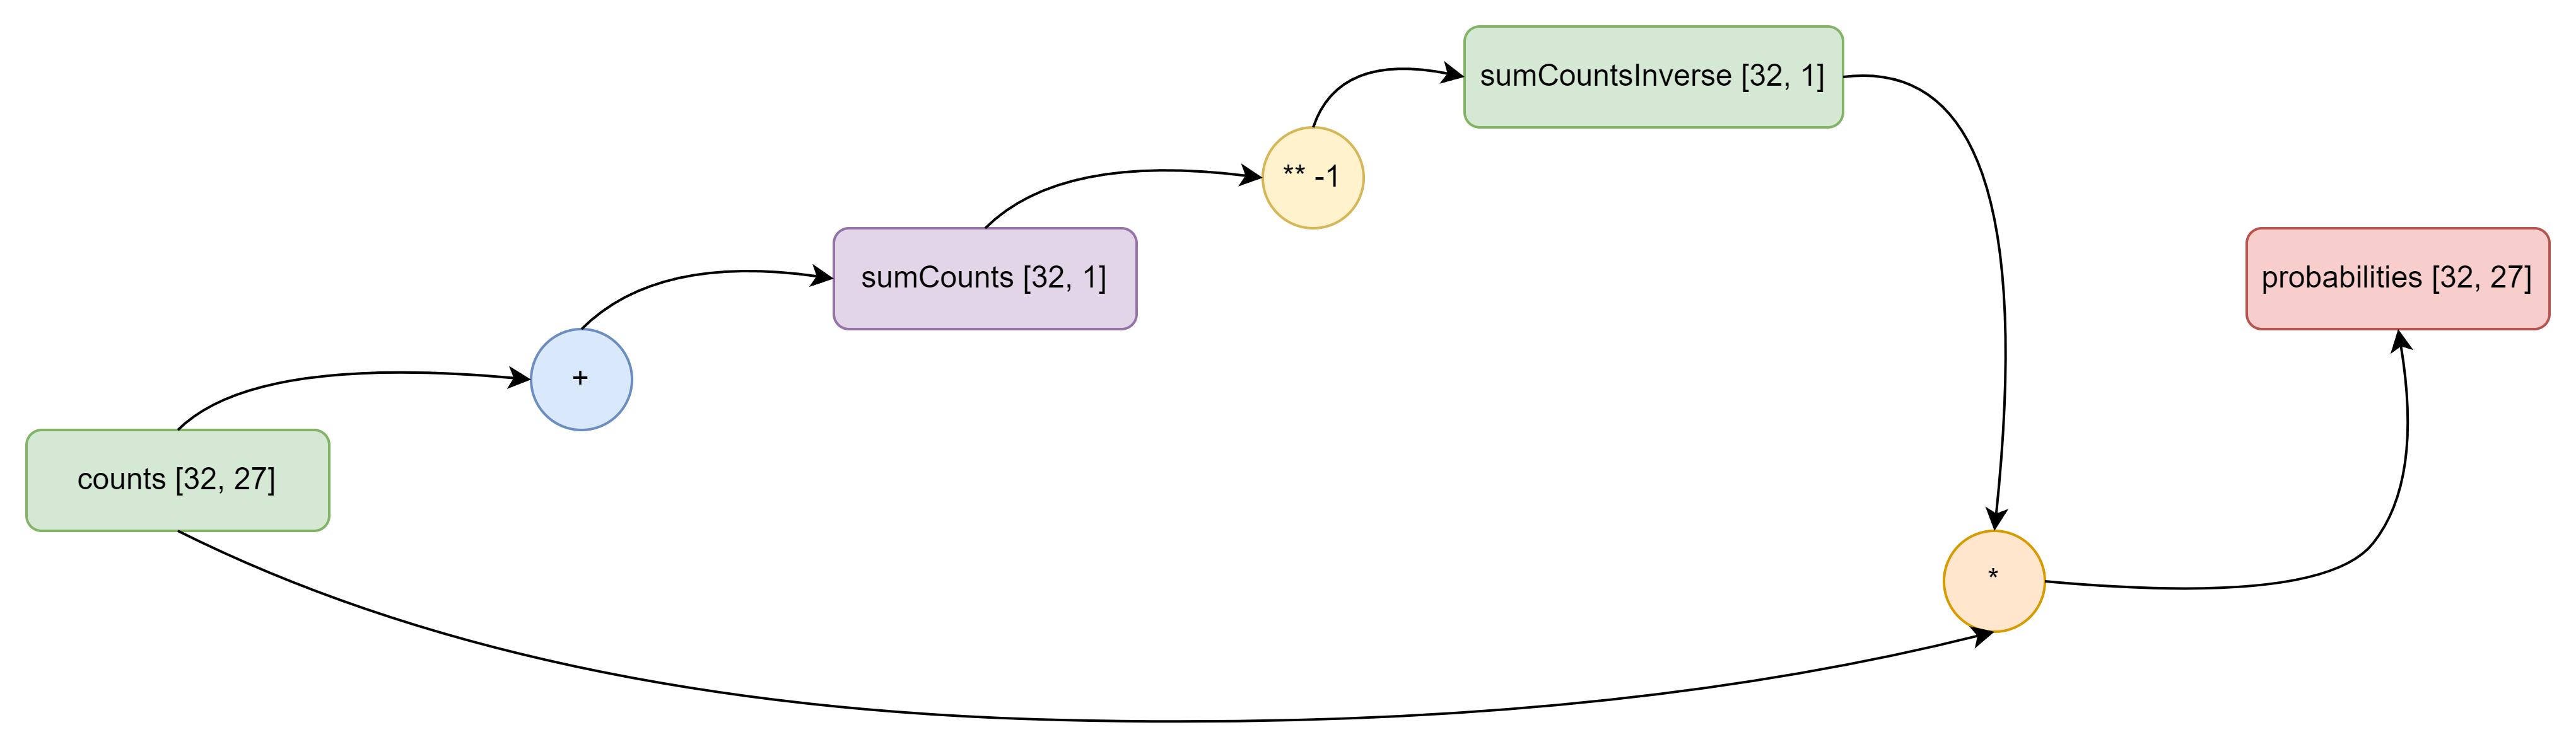

We clearly see that counts is associated in two places, so we cannot directly derive counts at the very beginning at a single time...

What to do now?

We know that if multiple branches add up at the end... So first we will derive what it looks like for now, and then again after deriving all the intermediate nodes, we will add up the operations...

Intuitively, right now we have this line:
```python
probabilities = counts * sumCountsInverse
```
From which we derived, `dSumCountsInverse` as `dSumCountsInverse = counts * dProbabilities`,\
Let's do the same for `'dCounts'` as `dCounts = sumCountsInverse * dProbabilities` for now... \
(Keep in mind we won't get a match until we calculate all the intermediate branches and add them up first.)

In [13]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0


You might be asking why we did not need any summation here?

Well it's simple really...

Here, it's a case of element wise operation and nothing gets replicated...

Let's now calculate the intermediate nodes...

The first intermediate expression is:
```python
sumCountsInverse = sumCounts**-1
```

Let's understand what $x^{-1}$ really is mathematically first...

We know,\
$$x^0 = 1$$
and 
$$\frac{x^m}{x^n} = x^{m-n}$$
So now,
$$\frac{1}{x} = \frac{x^0}{x^1} = x^{0-1} = x^{-1}$$

So, $$\frac{d}{dx}(\frac{1}{x}) = -\frac{1}{x^2} = -x^{-2}$$

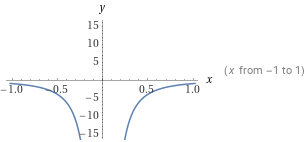

So chaining this local derivative operation along with our global derivative gives us:

In [14]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0


Now we arrive at the line:
```python
sumCounts = counts.sum(1, keepdims=True)
```

Let's once again understand what is happening using a *toy-example*:

<table>
<tr><td>

|          |          |          |
|----------|----------|----------|
| $a_{11}$ | $a_{12}$ | $a_{13}$ |
| $a_{21}$ | $a_{22}$ | $a_{23}$ |
| $a_{31}$ | $a_{32}$ | $a_{33}$ |

</td><td>

$\overrightarrow{\text{convert}}$

</td><td>

|       |
|-------|
| $b_1$ |
| $b_2$ |
| $b_3$ |

</td><td>

$=$

</td><td>

|                            |
|----------------------------|
| $a_{11} + a_{12} + a_{13}$ |
| $a_{21} + a_{22} + a_{23}$ |
| $a_{31} + a_{32} + a_{33}$ |

</td></tr> 
</table>

So we have to be careful about the shapes of `counts` and `sumCounts` now, as their shapes are `torch.Size([32, 27])` and `torch.Size([32, 1])` respectively...

So, looking at this example what do we realize?

We see that the derivative of $b_1$ basically depends on $a_{11}, a_{12} \text{ \& } a_{13}$, such that gradients flow through horizontally and all the gradients of other rows become 0.

So internally a replication is happening horizontally... \
Or in our example, $b_1$'s gradients will flow through the matrix $a$'s rows horizontally by replicating itself on top of its local derivative...\
Or in our case `'dSumCounts'` will flow through `'counts'` for the participating rows...

So we can now make broadcasting help us by internally replecating `'dSumCounts'` on top of 1s in their respective rows...

We also have to be careful because now we arrive at `'dCounts'` again, and as discussed before, because this is a second branch, their gradients will simply add up...

So we will use `+=` for adding our previous branch and current branch...

So now we have:

In [15]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0


That was a lot...

You can now pat yourself on the back and move to the next phase... :)

Now we arrive at the line:

```python
counts = normalizedLogits.exp()
```

Now what is `exp()` doing?

Well it's exponentiating.

So what is the local derivative of $e^x$?

We know that:
$$\frac{d}{dx}(e^x) = e^x$$

So what now? Chain-rule?\
You're absolutely right...

We can chain our $e^x$ with our global derivative `'dCounts'`...

Which becomes:

In [16]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts
dNormalizedLogits = counts * dCounts

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)
compare_gradients('dNormalizedLogits', dNormalizedLogits, normalizedLogits)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dNormalizedLogits                   | Exact: True  | Approximate: True  | MaxDiff: 0.0


Seems like you're getting the hang of it...

Let's look at what our part of forward pass looks like next:

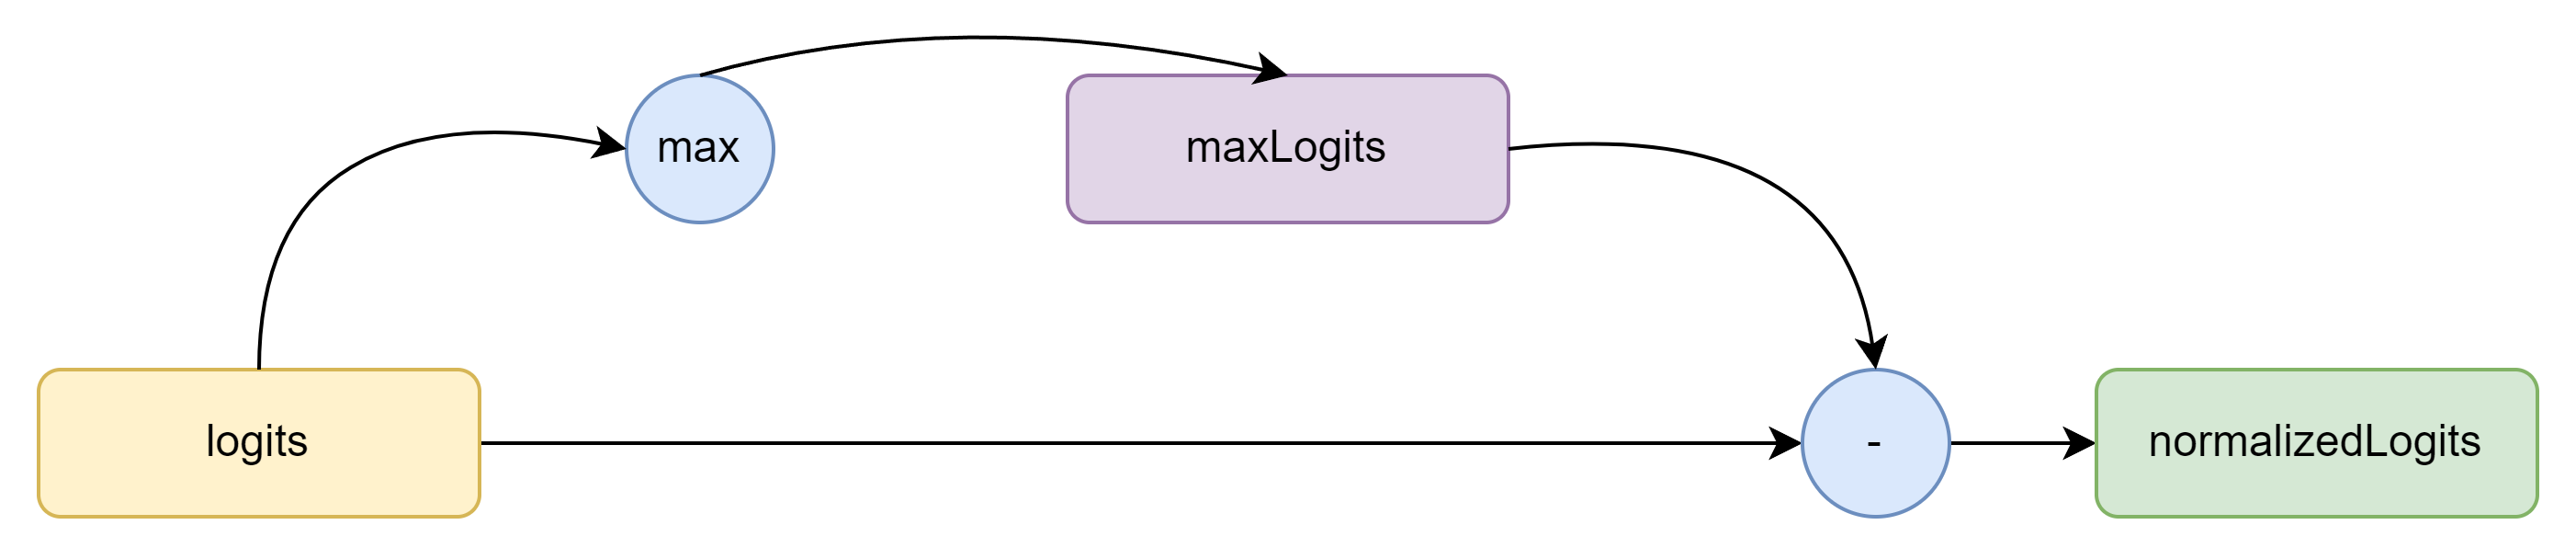

So we arrive at the line:
```python
normalizedLogits = logits - maxLogits # Subtracting it for numerical stability
```

Before back propagating through this line, what is this numerical stability?

Well, in our <a href="https://github.com/AvishakeAdhikary/Neural-Networks-From-Scratch/blob/main/NameWeave%20(MLP)%20-%20Activations%2C%20Gradients%20%26%20Batch%20Normalization.ipynb">NameWeave (MLP) - Activations, Gradients & Batch Normalization</a> notebook, I explained how extreme values can result in *infinity*.

This is the same thing we are trying to do...

Now we again have to be careful about the shapes because `normalizedLogits`, `logits` and `maxLogits` have the shapes `torch.Size([32, 27])`, `torch.Size([32, 27])` and `torch.Size([32, 1])` respectively...\
And so there's an implicit broadcasting that is happening in this `-`....

Let's again take a *toy-example* and try to understand what is happening here...

<table>
<tr><td>

|          |          |          |
|----------|----------|----------|
| $c_{11}$ | $c_{12}$ | $c_{13}$ |
| $c_{21}$ | $c_{22}$ | $c_{23}$ |
| $c_{31}$ | $c_{32}$ | $c_{33}$ |

</td><td>

$=$

</td><td>

|                            |
|----------------------------|
| $a_{11} + a_{12} + a_{13}$ |
| $a_{21} + a_{22} + a_{23}$ |
| $a_{31} + a_{32} + a_{33}$ |

</td><td>

$-$

</td><td>

|       |
|-------|
| $b_1$ |
| $b_2$ |
| $b_3$ |

</td><td>

$\rightarrow c_{mn} = a_{mn} - b_m$

</td></tr> 
</table>

​Now let's also understand the derivates of these `'c'`s with respect to their corresponding inputs:

1. Derivative with respect to $a_{mn}$:
   $$\frac{dc_{mn}}{da_{mn}} = 1$$
   To find $\frac{d}{da_{mn}}(c_{mn})$, we treat $b_m$ as a constant since it does not involve $a_{mn}$.
   $$\frac{d}{da_{mn}}(a_{mn} - b_m)$$
   Since $\frac{d}{dx}(x-y) = 1$, the derivative with respect to $a_{mn}$ is also 1.
3. Derivative with respect to $b_m$:
   $$\frac{dc_{mn}}{db_m} = -1$$
    ​To find $\frac{d}{db_{m}}(c_{mn})$, we treat $a_{mn}$ as a constant since it does not involve $b_m$.
   $$\frac{d}{db_m}(a_{mn} - b_m)$$
   Again, applying the constant rule, the derivative of a constant is 0.\
   So, we're left with:\
   $$\frac{d}{db_m}(-b_m)$$
   Since $\frac{d}{dx}(-x) = -1$, the derivative with respect to $b_m$ is also -1.

You see how derivative of $c_{mn}$ with respect to $a_{mn}$ is 1?

That means, the gradients of `normalizedLogits` will simply flow to `dLogits`, so we can simply make a copy of `dNormalizedLogits` to `dLogits` for now...\
And you also see how in our tabular example, `b`'s row elements are getting replecated and reused?\
So we can again make broadcasting help us in our favor and we can add them up, just like we did before(`dSumCountsInverse`)...

(Note: Once again `dLogits` is not our final logits, as I showed in the diagram above, that we have another branch for `Logits`, so we need to calculate all the intermediate branches and add up using `+=`. So for now we will only compare the gradients for `dMaxLogits`)

That leaves us with:

In [17]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts
dNormalizedLogits = counts * dCounts
dLogits = dNormalizedLogits.clone()
dMaxLogits = (-dNormalizedLogits).sum(1, keepdim=True)

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)
compare_gradients('dNormalizedLogits', dNormalizedLogits, normalizedLogits)
compare_gradients('dMaxLogits', dMaxLogits, maxLogits)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dNormalizedLogits                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dMaxLogits                          | Exact: True  | Approximate: True  | MaxDiff: 0.0


We also talked about how adding or subtracting any value equally to all of a `logit` row, it does not change the `probabilities`.\
Rather the only thing that subtracting a value does is to control the overflow of the `exp()` and we take the `max()` because we want the highest number that comes out of that *logit-row* is 0.

So, if it is the case that changing `maxLogits` does not change the `probabilities` and so it does not change the `loss`, then the gradient on logit maxes should be 0.

But when we print `dMaxLogits`, it comes out as something like this:
```python
tensor([[-3.0268e-09],
        [ 2.7940e-09],
        [ 4.8894e-09],
        [ 0.0000e+00],
        [ 4.6566e-09],
        [ 2.3283e-10],
        [-9.3132e-10],
        [-3.2596e-09],
        [ 3.4925e-09],
        [ 0.0000e+00],
        [ 6.0536e-09],
        [ 2.0955e-09],
        [-1.6298e-09],
        [ 5.5879e-09],
        [-1.1642e-09],
        [ 7.4506e-09],
        [ 4.6566e-09],
        [ 2.7940e-09],
        [-2.7940e-09],
        [-1.1642e-09],
        [ 3.2596e-09],
        [ 6.0536e-09],
        [ 2.7940e-09],
        [-5.1223e-09],
        [-1.1642e-09],
        [-4.1910e-09],
        [ 1.8626e-09],
        [-6.9849e-10],
        [ 3.2596e-09],
        [-8.1491e-09],
        [-9.3132e-10],
        [ 3.0268e-09]], grad_fn=<SumBackward1>)
```
which as you can see are very very small numbers...\
This happens because of the floating point *jerkiness* within PyTorch.

But what this essentially is telling us that the values of `maxLogits` is not impacting the `loss` (which they shouldn't).

So eventually you would like to even skip this branch sometimes, because it's only done for numerical stability...\
But for practice and depth, it is very interesting to see that, even if we break up the computation into all the pieces and still calculate everything, the "correct" thing happens and we get very very small numbers that do not affect the `loss`.

Yaay. 😊

Let's now calculate all the intermediate branches...

So we arrive at the line:
```python
maxLogits = logits.max(1, keepdim=True).values
```

Let's understand what are we doing here first...

For reference, `logits` has the shape of `torch.Size([32, 27])`, `maxLogits` has the shape of `torch.Size([32, 1])`.\
According to the line, we seem to take the *maximum* value along each row of `logits`.

But what is `.value` now?

If we look at `logits.max(1, keepdim=True)` we will see:
```python
torch.return_types.max(values=tensor(), indices=tensor())
```
We see that we get the `indices` and their corresponding `values`...\
During forward pass, it is not required to look at the `indices`, but during back propagation, it does...

Why you ask?

Well, during back propagation, we would like to know the participating `indices` to only fill the gradients in their positions.

We already know that:
$$\frac{d}{dx}(x) = 1$$

But here, `x` only participates, when it is the *maximum value*. That means that only the *participating-x*'s gradients will be 1 and all other *non-participating-x*'s will be 0.

So chaining up this local derivative with our global derivative `dMaxLogits` will give us the correct result...

This time we will take a slightly different approach...

We already know *one-hot encoding*, and how it can create a vector of all 0s with a single 1 in the vector to encode the position of something.\
That seems to correspond with what we want.

The thing to also keep in mind is that, *one-hot encoding* will only encode 1s for the maximum number of values we give it, and that's not what we want, we want to encode it for our `27` characters that we have, but we also don't want to *hard-code* any value, so instead we can take the `logits.shape[1]` to specify the number of classes we want in our *one-hot encoding*.

Let's first visualize what it looks like in an image plot...


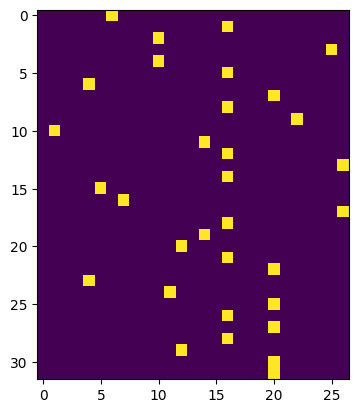

In [18]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

We can now understand that we will be scattering the gradients at the correct places with this piece of code.

But we need to chain it to the global derivative, that is `dMaxLogits`...\
And also because this is the second branch calculation for the `dLogits` we also need to use `+=` as discussed before...

So what we have now is:

In [19]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts
dNormalizedLogits = counts * dCounts
dLogits = dNormalizedLogits.clone()
dMaxLogits = (-dNormalizedLogits).sum(1, keepdim=True)
dLogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dMaxLogits

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)
compare_gradients('dNormalizedLogits', dNormalizedLogits, normalizedLogits)
compare_gradients('dMaxLogits', dMaxLogits, maxLogits)
compare_gradients('dLogits', dLogits, logits)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dNormalizedLogits                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dMaxLogits                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dLogits                             | Exact: True  | Approximate: True  | MaxDiff: 0.0


![Sweating Animated Cartoon](https://gifdb.com/images/high/animated-girl-wiping-sweat-elwb8vcr95kluwgq.gif)

Phew!!! That was a lot...

But, we did it!!!

We're done with the **cross-entropy** back propagation and we can now move on to our first **Linear Layer** from the bottom of the forward pass...

### Linear Layer - 2 Back Propagation

Let's see what the forward pass for a linear layer looks like with the example for our forward pass....

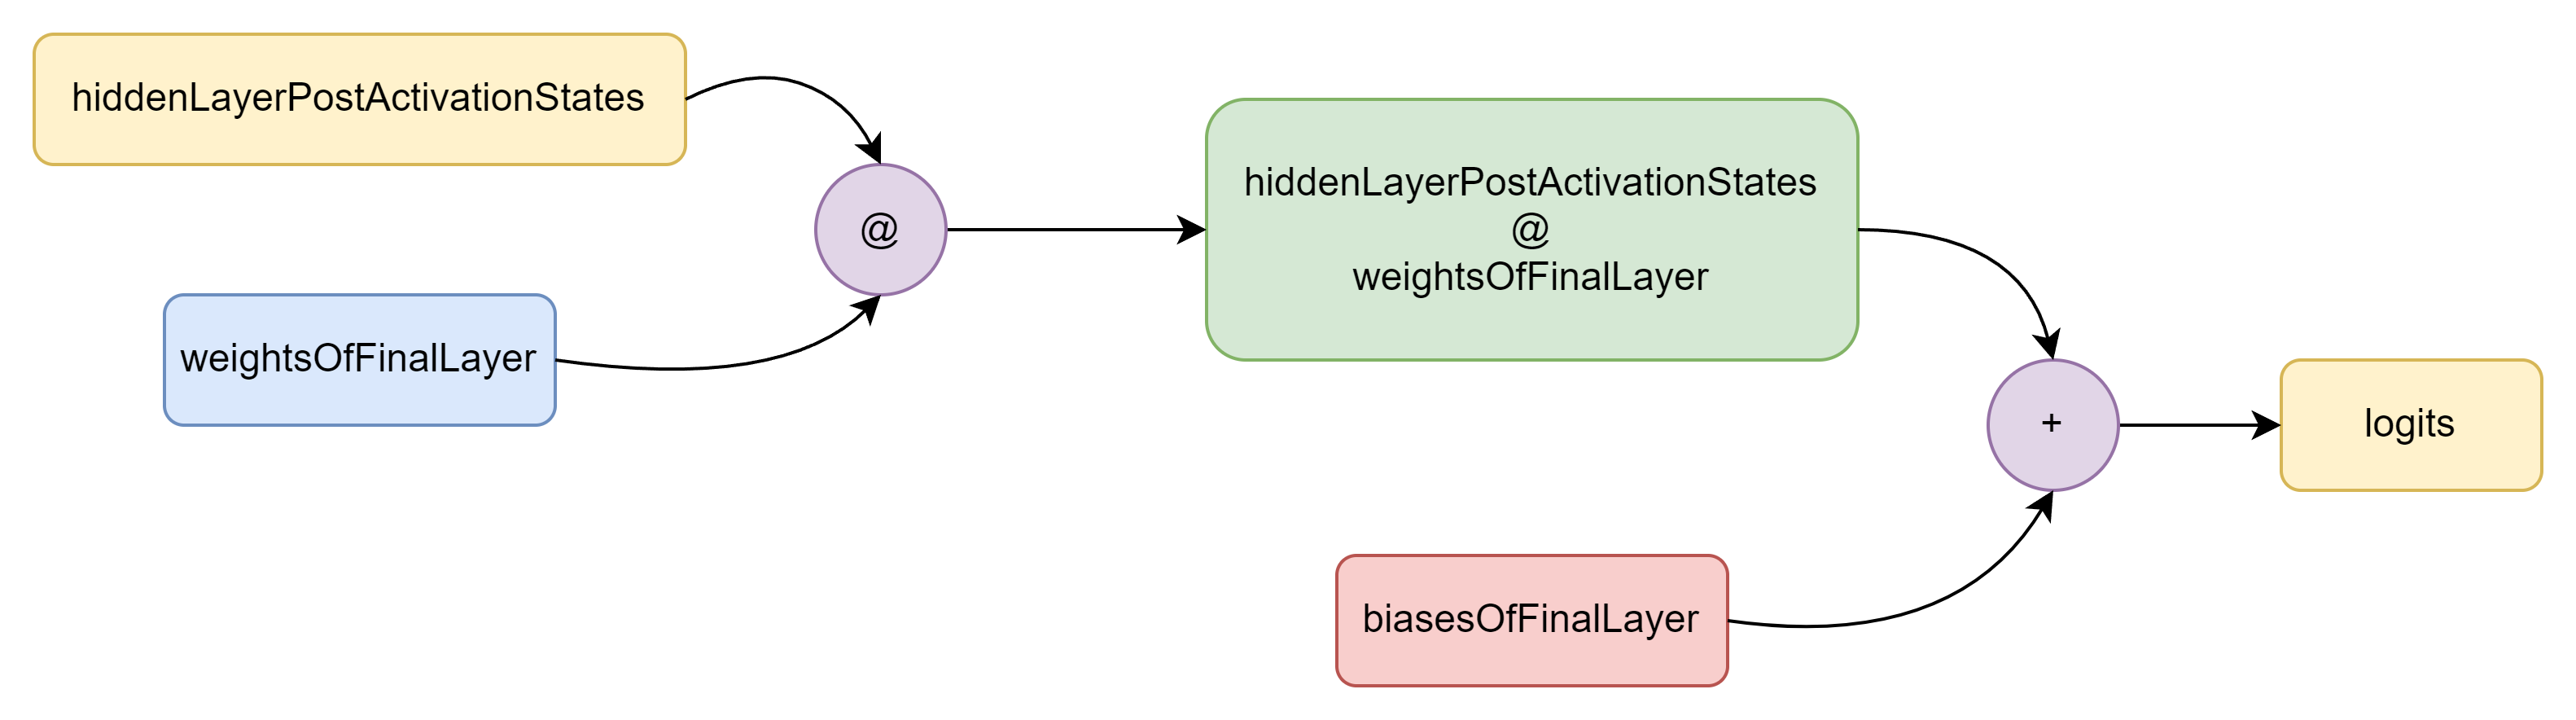

Now we arrive at the line:

```python
logits = hiddenLayerPostActivationStates @ weightsOfFinalLayer + biasesOfFinalLayer
```

Let's understand their sizes first:\
$$\underbrace{\text{logits}}_{[32, 27]} = \underbrace{\underbrace{\text{ hiddenLayerPostActivationStates }}_{[32, 64]} @ \underbrace{\text{ weightsOfFinalLayer }}_{[64, 27]}}_{[32, 27]} + \underbrace{\text{ biasesOfFinalLayer }}_{[27]}$$

The moment we look at the shapes, we realize that there's and internal broadcasting that is happening within the `+` operation of the above expression.

So what's happening is, the vector with `27` elements, gets a padded `1` dimension to broadcast itself with the other tensor, eventually making it a row vector of `[1, 27]`.\
And then because of our `@` the tensor becomes `[32, 27]`, to perform this `+` operation, it will replecate itself `32` times vertically to make it `[32, 27]` and do an element wise multiplication.

Now the only question remains is, how do we back propagate from `logits` to `hiddenLayerPostActivationStates`, `weightsOfFinalLayer` and `biasesOfFinalLayer`?

Now you might think that we might need some horrible and confusing matrix calculus and then we'd have to look at some derivative for matrix multiplication. But you don't have to do any of that, and we can do this on just a small piece of paper.

Not understandable?

Fear not, I have got you again with the *toy-examples* to make this way more simpler than what we expect...

Let's understand what I was talking about the broadcasting was going to be, for all the `biasesOfFinalLayer` with a *toy-example*:

<table>
<tr><td>
    
 $c_1$, $c_2$ 

</td><td>

$\overrightarrow{\text{pad}}$

</td><td>

|       |       |
|-------|-------|
| $c_1$ | $c_2$ |

</td><td>

$\overrightarrow{\text{replicate}}$

</td><td>

|       |       |
|-------|-------|
| $c_1$ | $c_2$ |
| $c_1$ | $c_2$ |

</td></tr> 
</table>

Now, what happens during the $\text{logits} = \text{ hiddenLayerPostActivationStates } @ \text{ weightsOfFinalLayer } + \text{ biasesOfFinalLayer }$?

<table>
<tr><td>
    
|          |          |
|----------|----------|
| $d_{11}$ | $d_{12}$ |
| $d_{21}$ | $d_{22}$ |

</td><td>

$=$

</td><td>

|          |          |
|----------|----------|
| $a_{11}$ | $a_{12}$ |
| $a_{21}$ | $a_{22}$ |

</td><td>

$.$

</td><td>

|          |          |
|----------|----------|
| $b_{11}$ | $b_{12}$ |
| $b_{21}$ | $b_{22}$ |

</td><td>

$+$

</td><td>

|       |       |
|-------|-------|
| $c_1$ | $c_2$ |
| $c_1$ | $c_2$ |

</td></tr>
</table>

So now, breaking up the expressions for each of these `d` elements, we have:

$$d_{11} = a_{11}b_{11} + a_{12}b_{21} + c_1 $$
$$d_{12} = a_{11}b_{12} + a_{12}b_{22} + c_2 $$
$$d_{21} = a_{21}b_{11} + a_{22}b_{21} + c_1 $$
$$d_{22} = a_{21}b_{12} + a_{22}b_{22} + c_2 $$

We seem to already have $\frac{dL}{dd}$, so all we need to do is calculate $\frac{dL}{da}$, $\frac{dL}{db}$ and $\frac{dL}{dc}$ for now...

So what is $\frac{dL}{da}$?

$$
\frac{dL}{da}
\rightarrow
\begin{bmatrix}
\frac{dL}{da_{11}}\ \frac{dL}{da_{12}}\\
\frac{dL}{da_{21}}\ \frac{dL}{da_{22}}
\end{bmatrix}
$$

Intuitively, let's just take $a_{11}$ as a single example for now...

See how $a_{11}$ has been used twice in all of these equations?
$$d_{11} = \underline{a_{11}}b_{11} + a_{12}b_{21} + c_1 $$
$$d_{12} = \underline{a_{11}}b_{12} + a_{12}b_{22} + c_2 $$
$$d_{21} = a_{21}b_{11} + a_{22}b_{21} + c_1 $$
$$d_{22} = a_{21}b_{12} + a_{22}b_{22} + c_2 $$

That once again means we have two branches of $a_{11}$.\
So we need to add them up, just like we did before in our equation.

So, using chain rule we are now left with:
$$\frac{dL}{da_{11}} = \underbrace{\frac{dL}{dd_{11}}.\frac{dd_{11}}{da_{11}}}_{branch-1} + \underbrace{\frac{dL}{dd_{12}}.\frac{dd_{12}}{da_{11}}}_{\text{branch-2}}$$
$$\implies \frac{dL}{dd_{11}}.\frac{d}{da_{11}}(a_{11}b_{11} + a_{12}b_{21} + c_1) + \frac{dL}{dd_{12}}.\frac{d}{da_{11}}(a_{11}b_{12} + a_{12}b_{22} + c_2)$$
$$\implies \frac{dL}{dd_{11}}.(\frac{d}{da_{11}}(a_{11}b_{11}) + \frac{d}{da_{11}}(a_{12}b_{21}) + \frac{d}{da_{11}}(c_1)) + \frac{dL}{dd_{12}}.(\frac{d}{da_{11}}(a_{11}b_{12}) + \frac{d}{da_{11}}(a_{12}b_{22}) + \frac{d}{da_{11}}(c_2))$$
Using
$$\frac{d}{dx}(xy) = y \text{ \& } \frac{d}{dx}(c) = 0$$
We get:
$$\implies \frac{dL}{dd_{11}}.(\underbrace{\frac{d}{da_{11}}(a_{11}b_{11})}_{b_{11}} + \underbrace{\frac{d}{da_{11}}(a_{12}b_{21})}_{0} + \underbrace{\frac{d}{da_{11}}(c_1)}_{0}) + \frac{dL}{dd_{11}}.(\underbrace{\frac{d}{da_{11}}(a_{11}b_{12})}_{b_{12}} + \underbrace{\frac{d}{da_{11}}(a_{12}b_{22})}_{0} + \underbrace{\frac{d}{da_{11}}(c_2)}_{0})$$

$$\therefore \frac{dL}{da_{11}} = \frac{dL}{dd_{11}}.(b_{11}) + \frac{dL}{dd_{12}}.(b_{12})$$

Well $a$ is a matrix, so we need to calculate each of these for our small *toy-example*..

Tired?\
Fear not, I have already calculated all of these examples already for you, but if you still want to derive them, you can once again do that in a small piece of paper (in fact, I invite you to derive them).

So we now have:

$$
\begin{rcases}
\begin{aligned}
\frac{dL}{da_{11}} &= \frac{dL}{dd_{11}} \cdot b_{11} + \frac{dL}{dd_{12}} \cdot b_{12}\\
\frac{dL}{da_{12}} &= \frac{dL}{dd_{12}} \cdot b_{22} + \frac{dL}{dd_{11}} \cdot b_{21}\\
\frac{dL}{da_{21}} &= \frac{dL}{dd_{21}} \cdot b_{11} + \frac{dL}{dd_{22}} \cdot b_{12}\\
\frac{dL}{da_{22}} &= \frac{dL}{dd_{22}} \cdot b_{22} + \frac{dL}{dd_{21}} \cdot b_{21}
\end{aligned}
\end{rcases}
\quad
\overrightarrow{\text{Align them in the same positions as a matrix}}
\quad
\begin{bmatrix}
\frac{dL}{da_{11}}\ \frac{dL}{da_{12}}\\
\frac{dL}{da_{21}}\ \frac{dL}{da_{22}}
\end{bmatrix}
\rightarrow
\frac{dL}{da}
$$

Before we go into the next explanation, let's understand a concept that we might have forgotten over the years. Which is transpose of a matrix...

So what is transpose of a matrix?

The transpose of a matrix is found by **interchanging its rows into columns or columns into rows**. The transpose of the matrix is denoted by using the letter `T` in the superscript of the given matrix.

For example:

If:
$$
a = 
\begin{bmatrix}
a_{11} \ a_{12}\\
a_{21} \ a_{22}
\end{bmatrix}
$$
Then:
$$
a^T = 
\begin{bmatrix}
a_{11} \ a_{21}\\
a_{12} \ a_{22}
\end{bmatrix}
$$

Also, we remember how a matrix multiplication works:

$$
\begin{bmatrix}
A_{11}\ A_{12}\\
A_{21}\ A_{22}
\end{bmatrix}
.
\begin{bmatrix}
B_{11}\ B_{12}\\
B_{21}\ B_{22}
\end{bmatrix}
\rightarrow
\begin{bmatrix}
A_{11}B_{11} + A_{12}B_{21}\ A_{11}B_{12} + A_{12}B_{22}\\
A_{21}B_{11} + A_{22}B_{21}\ A_{21}B_{12} + A_{22}B_{22}
\end{bmatrix}
$$

We can now expand our $\frac{dL}{da}$:
$$
\frac{dL}{da}
\rightarrow
\begin{bmatrix}
\frac{dL}{da_{11}}\ \frac{dL}{da_{12}}\\
\frac{dL}{da_{21}}\ \frac{dL}{da_{22}}
\end{bmatrix}
$$
$$
\implies
\begin{bmatrix}
\underbrace{\frac{dL}{dd_{11}} \cdot b_{11}}_{A_{11}B_{11}} + \underbrace{\frac{dL}{dd_{12}} \cdot b_{12}}_{A_{12}B_{21}}\ \ \ \ \underbrace{\frac{dL}{dd_{12}} \cdot b_{22}}_{A_{12}B_{22}} + \underbrace{\frac{dL}{dd_{11}} \cdot b_{21}}_{A_{11}B_{12}}\\
\underbrace{\frac{dL}{dd_{21}} \cdot b_{11}}_{A_{21}B_{11}} + \underbrace{\frac{dL}{dd_{22}} \cdot b_{12}}_{A_{22}B_{21}}\ \ \ \ \underbrace{\frac{dL}{dd_{22}} \cdot b_{22}}_{A_{22}B_{22}} + \underbrace{\frac{dL}{dd_{21}} \cdot b_{21}}_{A_{21}B_{12}}
\end{bmatrix}
\overrightarrow{\text{expressing them in form of matrix multiplication}}
\underbrace{\begin{bmatrix}
\frac{dL}{dd_{11}} \ \frac{dL}{dd_{12}}\\
\frac{dL}{dd_{21}} \ \frac{dL}{dd_{22}}
\end{bmatrix}}_{\frac{dL}{dd}}
\underbrace{\begin{bmatrix}
b_{11} \ b_{21}\\
b_{12} \ b_{22}
\end{bmatrix}}_{b^T}
$$
$$
\boxed{
\therefore
\implies
\frac{dL}{da} = \frac{dL}{dd} \text{ @ } b^T
}
$$

Great...

We can now move on to the next derivation part of our *toy-example*, which is $\frac{dL}{db}$...

This time we will be deriving the entire $\frac{dL}{db}$ for a detailed explanation, because the above explanation was short and you might get to see patterns in the mathematics, like I do...

So what is $\frac{dL}{db}$?

$$
\frac{dL}{db}
\rightarrow
\begin{bmatrix}
\frac{dL}{db_{11}}\ \frac{dL}{db_{12}}\\
\frac{dL}{db_{21}}\ \frac{dL}{db_{22}}
\end{bmatrix}
$$

For $\frac{dL}{b_{11}}$:

$$\frac{dL}{db_{11}} = \underbrace{\frac{dL}{dd_{11}}.\frac{dd_{11}}{db_{11}}}_{branch-1} + \underbrace{\frac{dL}{dd_{21}}.\frac{dd_{21}}{db_{11}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{11}}.\frac{d}{db_{11}}(a_{11}b_{11} + a_{12}b_{21} + c_1) + \frac{dL}{dd_{21}}.\frac{d}{db_{11}}(a_{21}b_{11} + a_{22}b_{21} + c_1)$$

Using

$$\frac{d}{dx}(xy) = y \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{11}}.\underbrace{\frac{d}{db_{11}}(a_{11}b_{11} + a_{12}b_{21} + c_1)}_{a_{11}} + \frac{dL}{dd_{12}}.\underbrace{\frac{d}{db_{11}}(a_{21}b_{11} + a_{22}b_{21} + c_1)}_{a_{21}}$$

$$\therefore \frac{dL}{db_{11}} = \frac{dL}{dd_{11}}.(a_{11}) + \frac{dL}{dd_{21}}.(a_{21})$$

For $\frac{dL}{b_{12}}$:

$$\frac{dL}{db_{12}} = \underbrace{\frac{dL}{dd_{12}}.\frac{dd_{12}}{db_{12}}}_{branch-1} + \underbrace{\frac{dL}{dd_{22}}.\frac{dd_{22}}{db_{12}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{12}}.\frac{d}{db_{12}}(a_{11}b_{12} + a_{12}b_{22} + c_2) + \frac{dL}{dd_{22}}.\frac{d}{db_{12}}(a_{21}b_{12} + a_{22}b_{22} + c_2)$$

Using

$$\frac{d}{dx}(xy) = y \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{12}}.\underbrace{\frac{d}{db_{12}}(a_{11}b_{12} + a_{12}b_{22} + c_2)}_{a_{11}} + \frac{dL}{dd_{22}}.\underbrace{\frac{d}{db_{12}}(a_{21}b_{12} + a_{22}b_{22} + c_2)}_{a_{21}}$$

$$\therefore \frac{dL}{db_{12}} = \frac{dL}{dd_{12}}.(a_{11}) + \frac{dL}{dd_{22}}.(a_{21})$$

For $\frac{dL}{b_{21}}$:

$$\frac{dL}{db_{21}} = \underbrace{\frac{dL}{dd_{11}}.\frac{dd_{11}}{db_{21}}}_{branch-1} + \underbrace{\frac{dL}{dd_{21}}.\frac{dd_{21}}{db_{21}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{11}}.\frac{d}{db_{21}}(a_{11}b_{11} + a_{12}b_{21} + c_1) + \frac{dL}{dd_{21}}.\frac{d}{db_{21}}(a_{21}b_{11} + a_{22}b_{21} + c_1)$$

Using

$$\frac{d}{dx}(xy) = y \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{11}}.\underbrace{\frac{d}{db_{21}}(a_{11}b_{11} + a_{12}b_{21} + c_1)}_{a_{12}} + \frac{dL}{dd_{21}}.\underbrace{\frac{d}{db_{21}}(a_{21}b_{11} + a_{22}b_{21} + c_1)}_{a_{22}}$$

$$\therefore \frac{dL}{db_{21}} = \frac{dL}{dd_{11}}.(a_{12}) + \frac{dL}{dd_{21}}.(a_{22})$$

For $\frac{dL}{b_{22}}$:

$$\frac{dL}{db_{22}} = \underbrace{\frac{dL}{dd_{12}}.\frac{dd_{12}}{db_{22}}}_{branch-1} + \underbrace{\frac{dL}{dd_{22}}.\frac{dd_{22}}{db_{22}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{12}}.\frac{d}{db_{22}}(a_{11}b_{12} + a_{12}b_{22} + c_2) + \frac{dL}{dd_{22}}.\frac{d}{db_{22}}(a_{21}b_{12} + a_{22}b_{22} + c_2)$$

Using

$$\frac{d}{dx}(xy) = y \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{12}}.\underbrace{\frac{d}{db_{22}}(a_{11}b_{12} + a_{12}b_{22} + c_2)}_{a_{12}} + \frac{dL}{dd_{22}}.\underbrace{\frac{d}{db_{22}}(a_{21}b_{12} + a_{22}b_{22} + c_2)}_{a_{22}}$$

$$\therefore \frac{dL}{db_{22}} = \frac{dL}{dd_{12}}.(a_{12}) + \frac{dL}{dd_{22}}.(a_{22})$$

Once again we have all the expressions like before:

$$
\begin{rcases}
\begin{aligned}
\frac{dL}{db_{11}} = \frac{dL}{dd_{11}}.(a_{11}) + \frac{dL}{dd_{21}}.(a_{21})\\
\frac{dL}{db_{12}} = \frac{dL}{dd_{12}}.(a_{11}) + \frac{dL}{dd_{22}}.(a_{21})\\
\frac{dL}{db_{21}} = \frac{dL}{dd_{11}}.(a_{12}) + \frac{dL}{dd_{21}}.(a_{22})\\
\frac{dL}{db_{22}} = \frac{dL}{dd_{12}}.(a_{12}) + \frac{dL}{dd_{22}}.(a_{22})
\end{aligned}
\end{rcases}
\quad
\overrightarrow{\text{Align them in the same positions as a matrix}}
\quad
\begin{bmatrix}
\frac{dL}{db_{11}}\ \frac{dL}{db_{12}}\\
\frac{dL}{db_{21}}\ \frac{dL}{db_{22}}
\end{bmatrix}
\rightarrow
\frac{dL}{db}
$$

We can now expand our $\frac{dL}{db}$:
$$
\frac{dL}{db}
\rightarrow
\begin{bmatrix}
\frac{dL}{db_{11}}\ \frac{dL}{db_{12}}\\
\frac{dL}{db_{21}}\ \frac{dL}{db_{22}}
\end{bmatrix}
$$
$$
\implies
\begin{bmatrix}
\underbrace{\frac{dL}{dd_{11}} \cdot a_{11}}_{B_{11}A_{11}} + \underbrace{\frac{dL}{dd_{21}} \cdot a_{21}}_{B_{21}A_{12}}\ \ \ \ \underbrace{\frac{dL}{dd_{12}} \cdot a_{11}}_{B_{12}A_{11}} + \underbrace{\frac{dL}{dd_{22}} \cdot a_{21}}_{B_{22}A_{12}}\\
\underbrace{\frac{dL}{dd_{11}} \cdot a_{12}}_{B_{11}A_{21}} + \underbrace{\frac{dL}{dd_{21}} \cdot a_{22}}_{B_{21}A_{22}}\ \ \ \ \underbrace{\frac{dL}{dd_{12}} \cdot a_{12}}_{B_{12}A_{21}} + \underbrace{\frac{dL}{dd_{22}} \cdot a_{22}}_{B_{22}A_{22}}
\end{bmatrix}
\overrightarrow{\text{expressing them in form of matrix multiplication}}
\underbrace{\begin{bmatrix}
a_{11} \ a_{21}\\
a_{12} \ a_{22}
\end{bmatrix}}_{a^T}
\underbrace{\begin{bmatrix}
\frac{dL}{dd_{11}} \ \frac{dL}{dd_{12}}\\
\frac{dL}{dd_{21}} \ \frac{dL}{dd_{22}}
\end{bmatrix}}_{\frac{dL}{dd}}
$$
$$
\boxed{
\therefore
\implies
\frac{dL}{db} = a^T \text{ @ } \frac{dL}{dd}
}
$$

Awesome...

We can now move on to the last derivation part of our *toy-example*, which is $\frac{dL}{dc}$...

So what is $\frac{dL}{dc}$?

$$
\frac{dL}{dc}
\rightarrow
\begin{bmatrix}
\frac{dL}{dc_{1}}\ \frac{dL}{dc_{2}}
\end{bmatrix}
$$

For $\frac{dL}{c_{1}}$:

$$\frac{dL}{dc_{1}} = \underbrace{\frac{dL}{dd_{11}}.\frac{dd_{11}}{dc_{1}}}_{branch-1} + \underbrace{\frac{dL}{dd_{21}}.\frac{dd_{21}}{dc_{1}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{11}}.\frac{d}{dc_{1}}(a_{11}b_{11} + a_{12}b_{21} + c_1) + \frac{dL}{dd_{21}}.\frac{d}{dc_{1}}(a_{21}b_{11} + a_{22}b_{21} + c_1)$$

Using

$$\frac{d}{dx}(x) = 1 \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{11}}.\underbrace{\frac{d}{dc_{1}}(a_{11}b_{11} + a_{12}b_{21} + c_1)}_{1} + \frac{dL}{dd_{21}}.\underbrace{\frac{d}{dc_{1}}(a_{21}b_{11} + a_{22}b_{21} + c_1)}_{1}$$

$$\implies \frac{dL}{dd_{11}}.(1) + \frac{dL}{dd_{21}}.(1)$$

$$\therefore \frac{dL}{dc_{1}} = \frac{dL}{dd_{11}} + \frac{dL}{dd_{21}}$$

For $\frac{dL}{c_{2}}$:

$$\frac{dL}{dc_{2}} = \underbrace{\frac{dL}{dd_{12}}.\frac{dd_{12}}{dc_{2}}}_{branch-1} + \underbrace{\frac{dL}{dd_{22}}.\frac{dd_{22}}{dc_{2}}}_{\text{branch-2}}$$

$$\implies \frac{dL}{dd_{12}}.\frac{d}{dc_{2}}(a_{11}b_{12} + a_{12}b_{22} + c_2) + \frac{dL}{dd_{22}}.\frac{d}{dc_{2}}(a_{21}b_{12} + a_{22}b_{22} + c_2)$$

Using

$$\frac{d}{dx}(x) = 1 \text{ \& } \frac{d}{dx}(c) = 0$$

We get:

$$\implies \frac{dL}{dd_{12}}.\underbrace{\frac{d}{dc_{2}}(a_{11}b_{12} + a_{12}b_{22} + c_2)}_{1} + \frac{dL}{dd_{22}}.\underbrace{\frac{d}{dc_{2}}(a_{21}b_{12} + a_{22}b_{22} + c_2)}_{1}$$

$$\implies \frac{dL}{dd_{12}}.(1) + \frac{dL}{dd_{22}}.(1)$$

$$\therefore \frac{dL}{dc_{2}} = \frac{dL}{dd_{12}} + \frac{dL}{dd_{22}}$$

You see, how for $\frac{dL}{dc}$, we are only left with $\frac{dL}{da}$'s?

If we closely look at what is happening along only $\frac{dL}{da}$'s shape we see:

$$
\begin{bmatrix}
\displaylines{
\begin{array}{cc}
\boxed{
\begin{matrix} 
\frac{dL}{dd_{11}} \\ 
\frac{dL}{dd_{21}} 
\end{matrix}} & 
\boxed{
\begin{matrix} 
\frac{dL}{dd_{12}} \\ 
\frac{dL}{dd_{22}} 
\end{matrix}} \\
\end{array}
}
\end{bmatrix}
$$
$$
\displaylines{
\text{sum across}\downarrow\text{columns} \\
\begin{bmatrix}
\frac{dL}{dc_{1}} \ \frac{dL}{dc_{2}}
\end{bmatrix} \rightarrow \frac{dL}{dc}
}
$$

That was scary...

But if all that math scares you, you should know that we don't even need to remember any of those formulas, we can simply derive all of that with just two principles.

Let's say that `output = 'input-1' @ 'input-2'`.

Then we can use the rules:

1. The shape of `'dinput-1'` must be the same as `'input-1'`
2. `'dinput-1'` must be some kind of matrix multiplication between `dOutput` and `'input-2'`, because back propagation of a matrix multiplication is a form of matrix multiplication.

So applying those principles,

We remember our forward pass, and we can validate our rules:
$$\underbrace{\text{logits}}_{[32, 27]} = \underbrace{\underbrace{\text{ hiddenLayerPostActivationStates }}_{[32, 64]} @ \underbrace{\text{ weightsOfFinalLayer }}_{[64, 27]}}_{[32, 27]} + \underbrace{\text{ biasesOfFinalLayer }}_{[27]}$$

So according to the rules,

If we want to get `dHiddenLayerPostActivationStates` for example:

1. `dHiddenLayerPostActivationStates` must be the same as `hiddenLayerPostActivationStates`
2. `hiddenLayerPostActivationStates` must be some kind of matrix multiplication between `dLogits` and `weightsOfFinalLayer`

We already know that `dlogits` is `[32, 27]`, `weightsOfFinalLayer` is `[64, 27]`, and `dHiddenLayerPostActivationStates` needs to be `[32, 64]` and for now there is only a single way to get `[32, 64]` as a result. That is, to multiply them we need to transpose `weightsOfFinalLayer` such that their shapes work themselves out during broadcasting, such that `[64, 27]` becomes `[27, 64]`.

And when we check, we see that we arrive at the same spot with the correct formula:

$$
\boxed{\frac{dL}{da} = \frac{dL}{dd} \text{ @ } b^T} \text{ and } \boxed{\frac{dL}{db} = a^T \text{ @ } \frac{dL}{dd}}
$$

So now when we derive both `dHiddenLayerPostActivationStates` and `dWeightsOfFinalLayer`, we have:

In [20]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts
dNormalizedLogits = counts * dCounts
dLogits = dNormalizedLogits.clone()
dMaxLogits = (-dNormalizedLogits).sum(1, keepdim=True)
dLogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dMaxLogits
dHiddenLayerPostActivationStates = dLogits @ weightsOfFinalLayer.T
dWeightsOfFinalLayer = hiddenLayerPostActivationStates.T @ dLogits

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)
compare_gradients('dNormalizedLogits', dNormalizedLogits, normalizedLogits)
compare_gradients('dMaxLogits', dMaxLogits, maxLogits)
compare_gradients('dLogits', dLogits, logits)
compare_gradients('dHiddenLayerPostActivationStates', dHiddenLayerPostActivationStates, hiddenLayerPostActivationStates)
compare_gradients('dWeightsOfFinalLayer', dWeightsOfFinalLayer, weightsOfFinalLayer)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dNormalizedLogits                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dMaxLogits                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dLogits                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dHiddenLayerPostActivationStates    | Exact: True  | Approximate: True  | MaxDiff: 0.0
dWeightsOfFinalLayer                | Exact: True  | Approximate: True  | MaxDiff: 0.0


Lastly, we have to derive `dBiasesOfFinalLayer` as well...

And again, we don't need to remember that we need to *sum-them-vertically-across-their-columns* at all.

Instead the piece of information we have is `biasesOfFinalLayer` has a shape of `27`, which is a dimension totally eliminated.

So we can take broadcasting rules to our favor and eleminate the dimension by simply summing the `dLogits` which has a dimension of `[32, 27]`, which eventually becomes `27` only, which is what we want...

So we have:

In [21]:
dLogProbabilities = torch.zeros_like(logProbabilities)
dLogProbabilities[range(batchSize), outputBatch] = -1.0/batchSize
dProbabilities = (1/probabilities) * dLogProbabilities
dSumCountsInverse = (counts * dProbabilities).sum(1, keepdim=True)
dCounts = sumCountsInverse * dProbabilities
dSumCounts = (-sumCounts**-2) * dSumCountsInverse
dCounts += torch.ones_like(counts) * dSumCounts
dNormalizedLogits = counts * dCounts
dLogits = dNormalizedLogits.clone()
dMaxLogits = (-dNormalizedLogits).sum(1, keepdim=True)
dLogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dMaxLogits
dHiddenLayerPostActivationStates = dLogits @ weightsOfFinalLayer.T
dWeightsOfFinalLayer = hiddenLayerPostActivationStates.T @ dLogits
dBiasesOfFinalLayer = dLogits.sum(0)

# Now we can compare our backpropagation implementation
compare_gradients('dLogProbabilities', dLogProbabilities, logProbabilities)
compare_gradients('dProbabilities', dProbabilities, probabilities)
compare_gradients('dSumCountsInverse', dSumCountsInverse, sumCountsInverse)
compare_gradients('dSumCounts', dSumCounts, sumCounts)
compare_gradients('dCounts', dCounts, counts)
compare_gradients('dNormalizedLogits', dNormalizedLogits, normalizedLogits)
compare_gradients('dMaxLogits', dMaxLogits, maxLogits)
compare_gradients('dLogits', dLogits, logits)
compare_gradients('dHiddenLayerPostActivationStates', dHiddenLayerPostActivationStates, hiddenLayerPostActivationStates)
compare_gradients('dWeightsOfFinalLayer', dWeightsOfFinalLayer, weightsOfFinalLayer)
compare_gradients('dBiasesOfFinalLayer', dBiasesOfFinalLayer, biasesOfFinalLayer)

dLogProbabilities                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dProbabilities                      | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCountsInverse                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dSumCounts                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dCounts                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dNormalizedLogits                   | Exact: True  | Approximate: True  | MaxDiff: 0.0
dMaxLogits                          | Exact: True  | Approximate: True  | MaxDiff: 0.0
dLogits                             | Exact: True  | Approximate: True  | MaxDiff: 0.0
dHiddenLayerPostActivationStates    | Exact: True  | Approximate: True  | MaxDiff: 0.0
dWeightsOfFinalLayer                | Exact: True  | Approximate: True  | MaxDiff: 0.0
dBiasesOfFinalLayer                 | Exact: True  | Approximate: True  | MaxDiff: 0.0
